In [1]:
import argparse
import re
import os.path
import glob

from pathlib import Path

from shared import *
from base import *
from RawScan import *
from skimage import measure
from load_model import Model
import utils

from unwarp import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model_path = "/Users/bojan/Documents/EPFL/Cini-Project/model_recto.ckpt"
m = Model(model_path, 11, 3, 3)
print("Got Model")

Got Model


In [3]:
image_path = "/Users/bojan/Documents/EPFL/3B/1A_635_recto.jpg"
img = utils.load_jpg_file_to_image(image_path)

In [4]:
mat = np.array(img.resize((1024, 688)))
mat = mat.reshape(1, 688, 1024, 3)
mat = mat.astype(np.uint8)

In [5]:
prediction = m.gen_prediction(mat)[0]

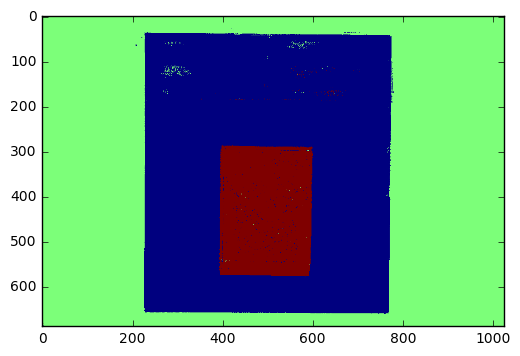

In [6]:
plt.imshow(prediction)

In [7]:
full_size_image = np.asarray(img.resize((2048, 1376)))

In [8]:
p, closing, angle, center_x, center_y = get_uwrap(prediction)

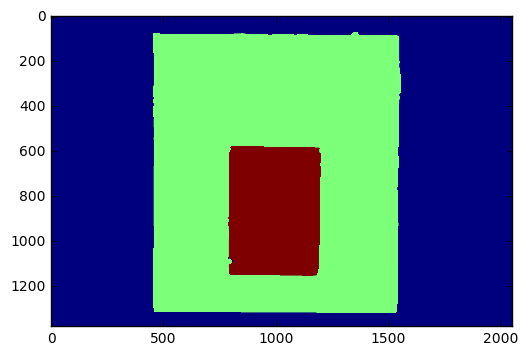

In [9]:
plt.imshow(closing)

In [10]:
def transform(xy):

    normalize = (np.max(xy[:, 0]) - np.min(xy[:, 0])) * (np.max(xy[:, 1]) - np.min(xy[:, 1]))
    x = xy[:, 1]
    y = xy[:, 0]
    radius = (np.square(x - center_x) + np.square(y - center_y)) / normalize
    coef_x = 1 + (radius * p[0][0]) + (np.square(radius) * p[0][1])
    coef_y = 1 + (radius * p[2][0]) + (np.square(radius) * p[2][1])

    add_x = ((p[1][1] * (radius + (2 * np.square(x)))) + (2 * p[1][0] * x * y)) * (
            1 + radius * p[1][2]) + (
                    np.square(radius) * p[1][3])
    add_y = ((p[3][1] * (radius + (2 * np.square(y)))) + (2 * p[3][0] * x * y)) * (
            1 + radius * p[3][2]) + (
                    np.square(radius) * p[3][3])

    x = (x * coef_x) + add_x
    y = (y * coef_y) + add_y
    xy = np.concatenate([y, x])

    return xy.astype(np.int32)


In [11]:
prediction = map_coordinates(closing, warp_coords(transform, closing.shape), order=1, prefilter=False)

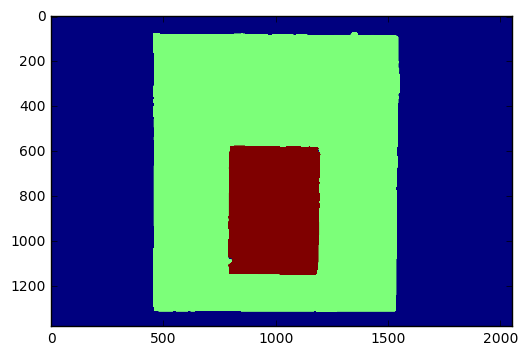

In [12]:
plt.imshow(prediction)

In [13]:
full_size_image = unwarp.rorate_image(full_size_image, angle)
warped_image = map_coordinates(full_size_image, warp_coords(transform, full_size_image.shape), order=1, prefilter=False)

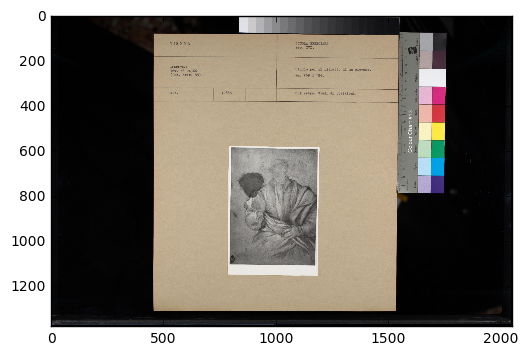

In [14]:
plt.imshow(warped_image)

In [15]:
    def crop_minAreaRect(img, rect):
        rect0 = (rect[0], rect[1], 0.0)
        box = cv2.boxPoints(rect)
        # rotate bounding bo
        pts = np.int0(box)
        img_crop = img[pts[1][0] + 1:pts[2][0] - 1, pts[1][1] - 1:pts[0][1] - 1]
        return img_crop

In [16]:
rect = cv2.minAreaRect(np.argwhere(prediction > 0))

In [17]:
croped_img = crop_minAreaRect(warped_image, rect)

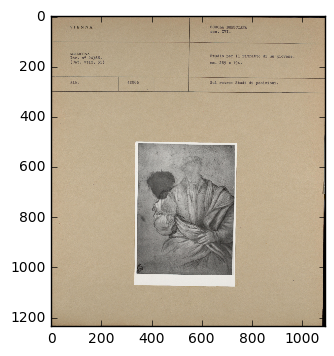

In [18]:
plt.imshow(croped_img)

In [ ]:
kernel = np.ones((5, 5), np.uint8)
closing = cv2.medianBlur(cv2.morphologyEx(prediction.astype(np.uint8), cv2.MORPH_OPEN, kernel), 5)

In [ ]:
plt.imshow(closing)

In [ ]:
closing[closing == 0] = 3
closing[closing == 1] = 0
closing[closing == 3] = 1

In [ ]:
plt.imshow(closing)

In [ ]:
closing = ndimage.interpolation.zoom(input=closing, zoom=2, order=0)

In [ ]:
plt.imshow(closing)

In [ ]:
angle = cv2.minAreaRect(np.argwhere(closing > 0))[2]
closing = unwarp.rorate_image(closing, angle)

In [ ]:
plt.imshow(closing)

In [ ]:
rect = cv2.boundingRect(np.argwhere(closing > 0))

In [ ]:
def get_largest_component(mat):
    max_sum = 0
    max_comp = 0
    i = 1

    while True:
        sum = np.sum(mat == i)
        if sum > max_sum:
            max_sum = sum
            max_comp = i
        if sum == 0:
            break
        i += 1

    mat[mat != max_comp] = 0
    mat[mat == max_comp] = 1

    return mat

In [ ]:
edges = cv2.Canny(closing.astype(np.uint8), 0, 5) - cv2.Canny(closing.astype(np.uint8), 0, 6)
edges = measure.label(edges)
edges = get_largest_component(edges)

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow(edges)